In [1]:
import pandas as pd
import ast
import numpy as np
import re
from collections import Counter
import string 
from pandas.core.frame import DataFrame
import seaborn as sns
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn import preprocessing
from mlxtend.frequent_patterns import apriori, association_rules


In [2]:
# read dataset.csv
df = pd.read_csv("Regional.csv",sep=';', encoding ='utf-8')

df.head()

,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url
0,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...
1,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,NaN,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...
2,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...
3,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,NaN,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...
4,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,NaN,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...


In [3]:
def remove_item(data, name):
    y = data[data[name] =='[]']
    index_r = y.index.tolist()
    data = data.drop(index = index_r)
    return data

In [4]:
def remove_null(data, name):
    y = data[data[name] =='0']
    index_n = y.index.tolist()
    data = data.drop(index = index_n)
    return data

In [5]:
def remove_None(data, name):
    y = data[data[name] == None]
    index_n = y.index.tolist()
    data = data.drop(index = index_n)
    return data

In [6]:
def tags_preprocess(tags):
    tags = tags.replace("'","")
    tags = tags.replace(" ","")
    tags = tags.replace("[","")
    tags = tags.replace("]","")
    tags = tags.split(",")
    tags = [x.lower() for x in tags]
    return tags

In [7]:
def most_frequent_country(data, num):
    count = {}
    r = re.compile('[A-Z]{1}[a-zA-Z]+')
    for i in range(len(data)):
        ingredients = data.loc[i]['ingredient']
        ingredient_propressing(ingredients)
        
        # store the frequency in count dictionary
        for ingredient in ingredients:
            ingre_count = count.get(ingredient, 0) + 1
            count[ingredient] = ingre_count
    
    #sort the dictionary based on the count
    sorted_count = sorted(count.items(), key=lambda kv: -kv[1])
    num_items = list(islice(sorted_count, num))

    return num_items

In [8]:
# check the null value in the dataset
# print(pd.isnull(df))

In [9]:
# data preprossing
# delete all the [] in every column

df = df.drop_duplicates(['recipe_url'])
df = remove_item(df, 'recipe_url')
df = remove_item(df, 'tags')
df = remove_item(df, 'comment_user')


# extract all the values from calorie and preparation time column
pat = r"([-+]?\d*\.\d+|\d+)"
df["pre_time"] = df["preparation_time"].str.extract(pat, flags=0, expand=True)
df["calorie_value"] = df["calorie"].str.extract(pat, flags=0, expand=True)
punct = set(string.punctuation) 

# data pre-processing
# If NaN for calorie and comment user -> change it to none!   
values_cal = {'calorie': 'none'}  
df = df.fillna(value=values_cal)
values_com = {'comment_user': 'no comment'} 
df = df.fillna(value=values_com)

In [10]:
# extract the recipe id from recipe urls
list_cat_no = []
i = 0
for item in df['recipe_url']:
    list_cat_no.append(item.split('/')[4])

# add one column "recipe_id" into the dataset and set it as the index of dataset
df['recipe_id'] = list_cat_no
df = df.set_index(["recipe_id"])
df

,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url,pre_time,calorie_value
recipe_id,,,,,,,,,,,,,
2040681330443605,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...,15,80
2419341381906336,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,none,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...,30,NaN
2208861353879796,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...,20,NaN
600611159796275,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...,20,NaN
614871161520252,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,none,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...,60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011711206349324,Regional,Bananen - Walnuss - Muffins,"['Backen', 'USAoderKanada', 'Kuchen']",3.6,normal,"['330g', 'Mehl', '1TL', 'Backpulver', '1Prise(...",8,none,20 Min,"[{'rating': 'rating-2', 'comment_time': '12.08...",https://www.chefkoch.de/rezepte/10117112063493...,20,NaN
1035991208758269,Regional,Putengeschnetzeltes in Mango - Bananen - Kokos...,"['Asien', 'Hauptspeise', 'Schnell', 'einfach',...",3.6,simpel,"['500g', 'Putenfleisch,geschnetzelt', 'n.B.', ...",3,340kcal,30 Min,"[{'rating': 'rating-5', 'comment_time': '28.04...",https://www.chefkoch.de/rezepte/10359912087582...,30,340
1339751238801256,Regional,Bananen - Pancakes,"['USAoderKanada', 'Frühstück', 'Braten', 'Süßs...",3.6,simpel,"['125g', 'Mehl,gesiebt', '1EL', 'Zucker', '2TL...",3,none,5 Min,"[{'rating': 'rating-3', 'comment_time': '13.08...",https://www.chefkoch.de/rezepte/13397512388012...,5,NaN


In [11]:
# tags propressing
# use the names of all regions to replace the tags
df.reset_index(inplace = True)
df['region'] = None
for i in range(len(df)):   
    tags = df.loc[i]['tags']
    tags = tags_preprocess(tags)

    if "europa" in tags:
        df.at[i,'region'] ='europa'
    if "afrika" in tags:
        df.at[i,'region'] ='afrika'
    if "asien" in tags:
        df.at[i,'region'] ='asien'
    if "amerika" in tags:
        df.at[i,'region'] ='amerika'
    if "australien" in tags:
        df.at[i,'region'] ='australien'
    if "karibikundexotik" in tags:
        df.at[i,'region'] ='other regions'
    if "mittlerer-undnaherosten" in tags:
        df.at[i,'region'] ='other regions'
    if "osteuropa" in tags:
        df.at[i,'region'] ='europa'
    if "usaoderkanada" in tags:
        df.at[i,'region'] ='amerika'
# add one column "recipe_id" into the dataset and set it as the index of dataset
# df['recipe_id'] = list_cat_no
df = df.set_index(["recipe_id"])



In [12]:
# add one column of countries' name
df.reset_index(inplace = True)
df['country'] = None
for i in range(len(df)):   
    tags = df.loc[i]['tags']
    tags = tags_preprocess(tags)
#     print(tags)
    if "ägypten" in tags:
        df.at[i,'country'] ='ägypten'
    if "marokko" in tags:
        df.at[i,'country'] ='marokko'
    if "südafrika" in tags:
        df.at[i,'country'] ='südafrika'
    if "lateinamerika" in tags:
        df.at[i,'country'] ='lateinamerika'
    if "australien" in tags:
        df.at[i,'country'] ='australien'
    if "china" in tags:
        df.at[i,'country'] ='china'
    if "indien" in tags:
        df.at[i,'country'] ='indien'
    if "japan" in tags:
        df.at[i,'country'] ='japan'
    if "usaoderkanada" in tags:
        df.at[i,'country'] ='usa & kanada'
    if "korea" in tags:
        df.at[i,'country'] ='korea'
    if "thailand" in tags:
        df.at[i,'country'] ='thailand'
    if "vietnam" in tags:
        df.at[i,'country'] ='vietnam'
    if "belgien" in tags:
        df.at[i,'country'] ='belgien'
    if "dänemark" in tags:
        df.at[i,'country'] ='dänemark'
    if "deutschland" in tags:
        df.at[i,'country'] ='deutschland'
    if "finnland" in tags:
        df.at[i,'country'] ='finnland'
    if "frankreich" in tags:
        df.at[i,'country'] ='frankreich'
    if "griechenland" in tags:
        df.at[i,'country'] ='griechenland'
    if "großbritannienirland" in tags:
        df.at[i,'country'] ='großbritannien & irland'
    if "italien" in tags:
        df.at[i,'country'] ='italien'
    if "luxemburg" in tags:
        df.at[i,'country'] ='luxemburg'
    if "malta" in tags:
        df.at[i,'country'] ='malta'
    if "niederlande" in tags:
        df.at[i,'country'] ='niederlande'
    if "norwegen" in tags:
        df.at[i,'country'] ='norwegen'
    if "österreich" in tags:
        df.at[i,'country'] ='österreich'
    if "polen" in tags:
        df.at[i,'country'] ='polen'
    if "portugal" in tags:
        df.at[i,'country'] ='portugal'
    if "russland" in tags:
        df.at[i,'country'] ='russland'
    if "schweden" in tags:
        df.at[i,'country'] ='schweden'
    if "schweiz" in tags:
        df.at[i,'country'] ='schweiz'
    if "spanien" in tags:
        df.at[i,'country'] ='spanien'
    if "tschechien" in tags:
        df.at[i,'country'] ='tschechien'
    if "türkei" in tags:
        df.at[i,'country'] ='türkei'
    if "ungarn" in tags:
        df.at[i,'country'] ='ungarn'
    if "weißrussland" in tags:
        df.at[i,'country'] ='russland'
    if "mittlerer-undnaherosten" in tags:
        df.at[i,'country'] ='other countries'

        
# add one column "recipe_id" into the dataset and set it as the index of dataset
# df['recipe_id'] = list_cat_no
df = df.set_index(["recipe_id"])
df.head()

,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url,pre_time,calorie_value,region,country
recipe_id,,,,,,,,,,,,,,,
2040681330443605,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...,15,80,other regions,other countries
2419341381906336,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,none,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...,30,NaN,europa,italien
2208861353879796,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...,20,NaN,europa,deutschland
600611159796275,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...,20,NaN,europa,portugal
614871161520252,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,none,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...,60,NaN,europa,deutschland


# Regional Data Exploration

In [13]:
# divide the dataset into different region groups
# data = data.droindndex = index_n)
group_region = df.groupby('region').count()

data_region = pd.DataFrame(group_region['recipe_name'])
# data_region

## Pie chart for different regions

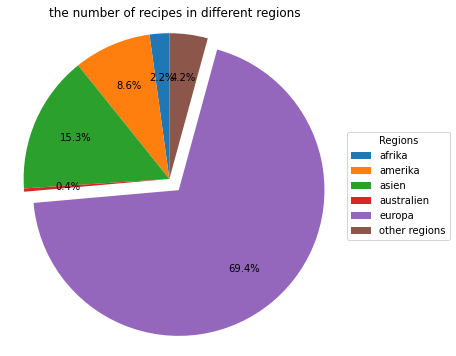

In [14]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'afrika', 'amerika', 'asien', 'australien','europa','other regions'
sizes = group_region['recipe_name']
explode = (0, 0, 0, 0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',pctdistance= 0.7,
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.legend(labels,
          title="Regions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax1.set_title("the number of recipes in different regions")

plt.show()

## the number of recipes in different regions

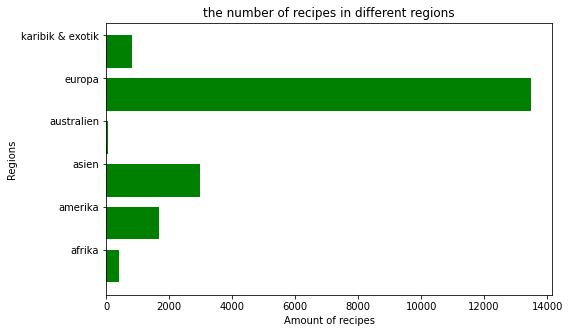

In [15]:
x = [u'afrika', u'amerika', u'asien', u'australien', u'europa', u'karibik & exotik', u'mittlerer & naher osten', u'osteuropa']
y = data_region['recipe_name']
fig, ax = plt.subplots(figsize=(8, 5))    

width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('the number of recipes in different regions')
plt.xlabel('Amount of recipes')
plt.ylabel('Regions')
plt.show()

## the number of recipes in different countries

In [16]:
group_country_1 = df.groupby('country').count()
group_country_2 = df.groupby(['country','region']).count()
# group_country_1
data_country_1= pd.DataFrame(group_country_1['recipe_name'])
data_country_2= pd.DataFrame(group_country_2['recipe_name'])
data_country_1['countries'] = data_country_1.index
data_country_2['countries'] = data_country_2.index
data_country_2.sort_values("recipe_name",inplace=True, ascending=False)
data_country_1.sort_values("recipe_name",inplace=True, ascending=False)

# data_country_1
# data_country_2.head(37)

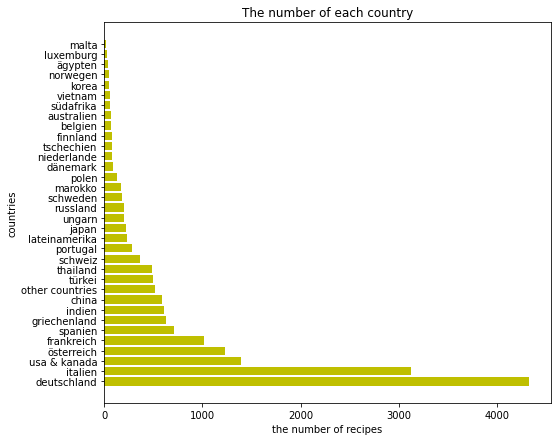

In [17]:
plt.figure(figsize=(8, 7))
plt.barh('countries', 'recipe_name', data = data_country_1, color = 'y')
plt.xlabel("the number of recipes")
plt.ylabel("countries")
plt.title("The number of each country")
plt.show()

# Recipe Rating Distribution based on average score

In [18]:
# delete the recipes, which have no average score.
df_avg = remove_null(df,'avg_score')
df_avg = remove_item(df_avg,'avg_score')

# df_avg = df_avg.set_index(["avg_score"])
# df_avg
avg_count = df_avg['avg_score'].value_counts()
df_avg_count = avg_count.to_frame()
df_avg_count['score'] = avg_count.index.tolist()
# df_avg_count

# df_avg_count = df_avg_count.set_index(["avg_score"])
# df_avg_count
# list_count = avg_count.values.tolist()
# list_count
# list_score = avg_count.index.tolist()
# list_score


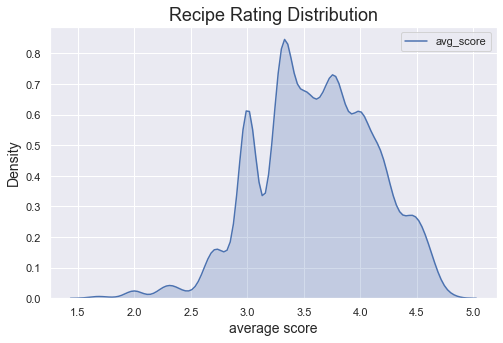

In [19]:
plt.figure(figsize=(8, 5))
sns.set()
sns.kdeplot(df_avg['avg_score'], shade=True)
plt.title('Recipe Rating Distribution', fontsize=18)
# plt.xlim(-0.5,5.5,0.8)
plt.ylabel('Density',fontsize=14)
plt.xlabel('average score',fontsize=14)
plt.show()

# preparation time  distribution of recipes in different regions

In [20]:
# delete recipes, which has the most high preparation time but only one
df_time = remove_null(df,'preparation_time')
df_time = remove_item(df,'preparation_time')
df_time = df.groupby('preparation_time').filter(lambda x: len(x) > 10)

# divide the recipes into different preparation time groups
def pre_time_group(pre_time):   
    pre_time = int(pre_time)    
    if pre_time < 20:
        bucket = '<20 Min'    
    if pre_time in range(20, 41):
        bucket = '20-40 Min'        
    if pre_time in range(40, 61):
        bucket = '40-60 Min'        
    if pre_time in range(60, 81):
        bucket = '60-80 Min'
    if pre_time >= 81:
        bucket = '80+ Min'
    return bucket

df_time['pretime_group'] = df_time['pre_time'].apply(pre_time_group)
df_time.head()

/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url,pre_time,calorie_value,region,country,pretime_group
recipe_id,,,,,,,,,,,,,,,,
2040681330443605,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...,15,80,other regions,other countries,<20 Min
2419341381906336,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,none,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...,30,NaN,europa,italien,20-40 Min
2208861353879796,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...,20,NaN,europa,deutschland,20-40 Min
600611159796275,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...,20,NaN,europa,portugal,20-40 Min
614871161520252,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,none,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...,60,NaN,europa,deutschland,60-80 Min


In [21]:
group_time = df_time.groupby('pretime_group').count()
data_time = pd.DataFrame(group_time['recipe_name'])
data_time = data_time.reindex(index = ['<20 Min','20-40 Min','40-60 Min','60-80 Min','80+ Min'])
data_time

,recipe_name
pretime_group,
<20 Min,4891
20-40 Min,11531
40-60 Min,2539
60-80 Min,1104
80+ Min,257


Text(0.5, 1.0, 'preparation time distribution')

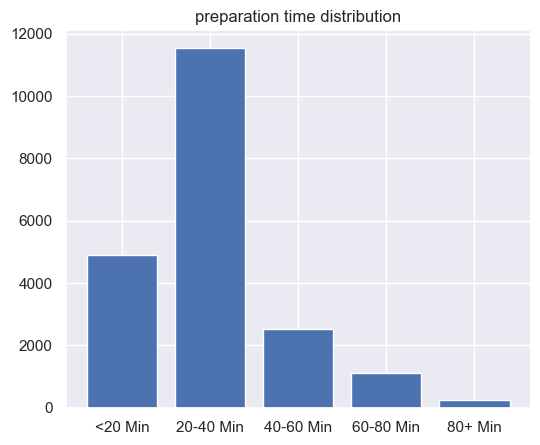

In [22]:
fig, axes = plt.subplots(figsize=(6,5), dpi=100)
plt.bar(data_time.index, height=data_time.recipe_name)
plt.title('preparation time distribution')

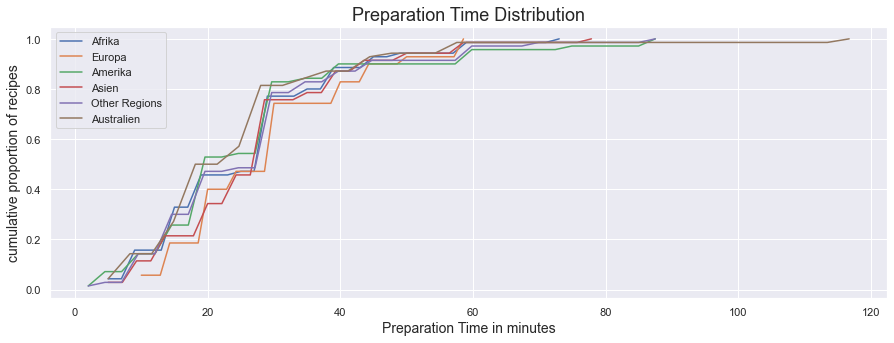

In [23]:
# Plot the cooking time's cumulative distribution for a sample of european and asian countries.
plt.figure(figsize=(15,5))
x1 = list(df_time[df_time['region'] == 'afrika']['pre_time'])
x2 = list(df_time[df_time['region'] == 'europa']['pre_time'])
x3 = list(df_time[df_time['region'] == 'amerika']['pre_time'])
x4 = list(df_time[df_time['region'] == 'asien']['pre_time'])
x5 = list(df_time[df_time['region'] == 'other regions']['pre_time'])
x6 = list(df_time[df_time['region'] == 'australien']['pre_time'])

pretime_sample = pd.concat([pd.DataFrame({'afrika': x1}), 
                            pd.DataFrame({'europa':x2}), 
                            pd.DataFrame({'amerika':x3}),
                            pd.DataFrame({'asien':x4}),
                            pd.DataFrame({'other regions':x5}),
                            pd.DataFrame({'australien':x6})], axis=1)
pretime_sample = pretime_sample.dropna()
pretime_sample
# For each cuisine compute the cumulative distribution of the preparation time and plot it.
for item in pretime_sample:
    pre = pretime_sample[item].astype(np.float)
    prep_times = pretime_sample[item].astype(np.float)
    values, base = np.histogram(prep_times, bins=35)
    # Compute the cumulative distribution
    cumulative = np.cumsum(values)
    cumulative = cumulative/cumulative.max()
    ax = plt.plot(base[:-1], cumulative)

plt.ylabel("cumulative proportion of recipes", fontsize=14)
plt.xlabel("Preparation Time in minutes", fontsize=14)
plt.legend([c_title.title() for c_title in pretime_sample])
plt.title('Preparation Time Distribution',fontsize=18)
plt.grid(True)

# Who eat what in different regional recipes

In [24]:
# extract comment user dataset from original dataset
def extract_com_user(data):
    df_com = pd.DataFrame()
    for index, item in data['comment_user'].iteritems():
        if (item != '[]'):
            if (item != 'no comment'):
                array = ast.literal_eval(item)
                df_array = pd.DataFrame(array)
                df_array['recipe_id'] = index
                df_com = pd.concat([df_com,df_array])
    return df_com

In [25]:
def sub_cat_in_com(data):
    list_sub_cat = []
    list_country = []
    df_com2 = pd.DataFrame()
    for index_1, item_1 in data['region'].iteritems(): 
        if (item_1 != None):
            list_sub = list(item_1)
            list_sub = ''.join(x for x in list_sub if x not in punct)
            list_sub_cat.append(list_sub)
    df_sub_cat = pd.DataFrame(list_sub_cat)
    df_sub_cat['region'] = df_sub_cat

    for index, item in data['country'].iteritems(): 
        if (item != None):
            list_cou = list(item)
            list_cou = ''.join(x for x in list_cou if x not in punct)

            list_country.append(list_cou)

    df_cou = pd.DataFrame(list_country)
    df_sub_cat['country'] = df_cou
    df_sub_cat['recipe_id'] = data['region'].index     
    df_com2 = pd.concat([df_com2,df_sub_cat])
    return df_com2

In [26]:
data_com = df[['comment_user','region','country']]
data_com = data_com[0:5000]
data_com
# remove None value in dataset
data_com = data_com.dropna(subset=['region'])
data_com = data_com.dropna(subset=['country'])

df_com = extract_com_user(data_com)
df_com2 = sub_cat_in_com(data_com)

df_com_new = df_com.merge(df_com2, on='recipe_id', how='left')
df_com_new = df_com_new.drop(0, 1)
df_com_new = df_com_new[['recipe_id','name','rating','sex','age','marriage_status','job','country','region','comment_time']]

df_com_new.dropna()
df_com_new.head()

,recipe_id,name,rating,sex,age,marriage_status,job,country,region,comment_time
0,2040681330443605,Assibaby,rating-5,weiblich,None,None,None,other countries,other regions,08.04.2013 18:59
1,2040681330443605,diekochfrau,rating-4,None,35 Jahre,None,Marktfahrer,other countries,other regions,13.01.2013 19:27
2,2040681330443605,Entelekta,rating-5,männlich,41 Jahre,None,Selbstständig,other countries,other regions,12.03.2012 20:03
3,2419341381906336,Parmigiana,rating-4,weiblich,None,None,selbständig/freiberuflich,italien,europa,18.03.2020 17:16
4,2419341381906336,bahnhof1,rating-5,None,None,None,vielseitig,italien,europa,05.04.2014 14:30


In [27]:
df_com_new["age_num"] = df_com_new["age"].str.extract(pat, flags=0, expand=True)
df_com_new["rating_num"] = df_com_new["rating"].str.extract(pat, flags=0, expand=True)


In [28]:
df_null_age = df_com_new[df_com_new['age'] =='None']
df_null_age
index_a = df_null_age.index.tolist()
df_age = df_com_new.drop(index =index_a)
df_age["age_num"] = df_age["age"].str.extract(pat, flags=0, expand=True)
df_age

,recipe_id,name,rating,sex,age,marriage_status,job,country,region,comment_time,age_num,rating_num
1,2040681330443605,diekochfrau,rating-4,None,35 Jahre,None,Marktfahrer,other countries,other regions,13.01.2013 19:27,35,4
2,2040681330443605,Entelekta,rating-5,männlich,41 Jahre,None,Selbstständig,other countries,other regions,12.03.2012 20:03,41,5
5,2208861353879796,nutellaweggle,rating-5,männlich,58 Jahre,None,None,deutschland,europa,15.05.2019 18:24,58,5
7,600611159796275,JuanaLaLoca,rating-4,weiblich,57 Jahre,Verheiratet,selbständig,portugal,europa,09.03.2007 15:55,57,4
9,614871161520252,vfb-moni,rating-5,weiblich,60 Jahre,Single,Sekretärin,deutschland,europa,30.12.2012 12:03,60,5
...,...,...,...,...,...,...,...,...,...,...,...,...
35303,472841140860266,eichhoernchen369,rating-3,weiblich,39 Jahre,Verheiratet,None,österreich,europa,26.07.2010 17:33,39,3
35304,472841140860266,ClaudiaMaria1973,rating-4,weiblich,46 Jahre,Verheiratet,Industriekauffrau,österreich,europa,02.05.2010 17:59,46,4
35306,776811180688163,niki30,rating-4,weiblich,43 Jahre,None,Verkäuferin,australien,australien,12.03.2008 20:39,43,4
35308,683801170861114,Flar,rating-4,männlich,66 Jahre,Vergeben,Software Berater,portugal,europa,16.06.2008 00:45,66,4


In [29]:
def age_group(age):   
    age = int(age)    
    if age < 30:
        bucket = '<30 Jahre'    
    if age in range(30, 41):
        bucket = '30-40 Jahre'        
    if age in range(40, 51):
        bucket = '40-50 Jahre'        
    if age in range(50, 61):
        bucket = '50-60 Jahre'
    if age >= 61:
        bucket = '60+ Jahre'
    return bucket

In [30]:
df_age['age_group'] = df_age['age_num'].apply(age_group)
df_age = df_age.groupby('country').filter(lambda x: len(x) > 500)

group_age = df_age.groupby(['age_group','country']).count()

group_age_1 = group_age['rating']
group_age_1
df_group_age_1 = pd.DataFrame(group_age_1)

# df_group_age_1

In [31]:
df_1 = df_group_age_1.iloc[0:9]
df_1['sum'] = 5515
df_1['scaled'] = df_1.apply(lambda x: x['rating'] / x['sum'], axis=1)

df_2 = df_group_age_1.iloc[9:18]
df_2['sum'] = 3870
df_2['scaled'] = df_2.apply(lambda x: x['rating'] / x['sum'], axis=1)

df_3 = df_group_age_1.iloc[18:27]
df_3['sum'] = 2981
df_3['scaled'] = df_3.apply(lambda x: x['rating'] / x['sum'], axis=1)

df_4 = df_group_age_1.iloc[27:36]
df_4['sum'] = 1307
df_4['scaled'] = df_4.apply(lambda x: x['rating'] / x['sum'], axis=1)

df_5 = df_group_age_1.iloc[36:45]
df_5['sum'] = 1719
df_5['scaled'] = df_5.apply(lambda x: x['rating'] / x['sum'], axis=1)

frames = [df_1,df_2,df_3,df_4,df_5]
df_group_age_scaled = pd.concat(frames)
df_group_age_scaled = df_group_age_scaled['scaled']
# df_group_age_scaled


/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Text(0.5, 1.0, 'Age group Distribution')

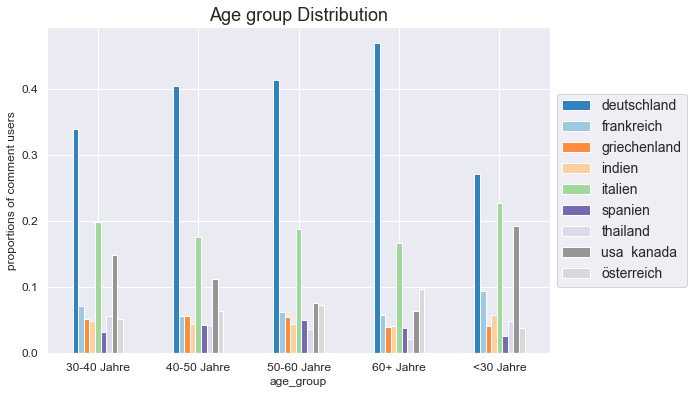

In [32]:
fig, ax = subplots()
df_group_age_scaled.unstack().plot(kind='bar',ax=ax, fontsize = 12,figsize=(9,6),rot=0, colormap='tab20c')
ax.legend(fontsize=12)
plt.ylabel('proportions of comment users')

plt.legend(fontsize=14,bbox_to_anchor=(1,0.5),loc='center left')
plt.title('Age group Distribution',fontsize=18)


In [33]:
t = df_com_new[df_com_new['sex'] == 'None']
index_m = t.index.tolist()
index_m
df_sex = df_com_new.drop(index =index_m)
df_sex
df_sex = df_sex.groupby('country').filter(lambda x: len(x) > 300)
group_sex = df_sex.groupby(['sex','country']).count()


# g = df_groupby['count'].groupby(level=0, group_keys=False)  # 更多信息见下边备注
# res = g.nlargest(3)
group_sex = group_sex['rating']
group_sex = pd.DataFrame(group_sex)
# group_sex


In [34]:
# calculate the probability of male and female comment users 
df_sex_1 = group_sex.iloc[0:14]
df_sex_1['sum'] = 5214
df_sex_1['scaled'] = df_sex_1.apply(lambda x: x['rating'] / x['sum'], axis=1)

df_sex_2 = group_sex.iloc[14:28]
df_sex_2['sum'] = 23353
df_sex_2['scaled'] = df_sex_2.apply(lambda x: x['rating'] / x['sum'], axis=1)

frames_s = [df_sex_1,df_sex_2]
df_group_sex_scaled = pd.concat(frames_s)
df_group_sex_scaled = df_group_sex_scaled['scaled']
# df_group_sex_scaled

/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a cop

Text(0.5, 1.0, 'Sex group Distribution')

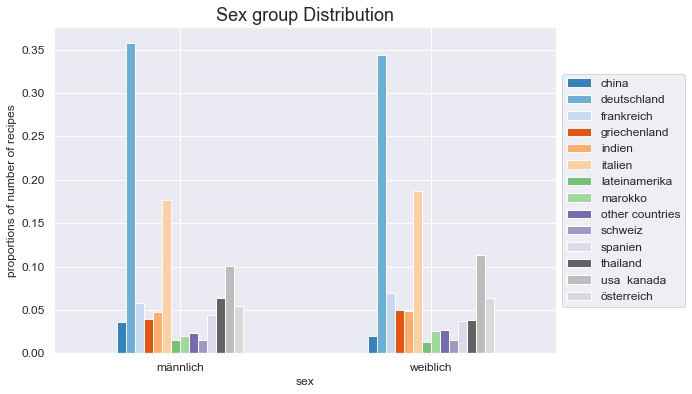

In [35]:
# group_sex.loc['männlich','rating']
# group_sex.loc['weiblich','rating']
fig, ax = subplots()
df_group_sex_scaled.unstack().plot(kind='bar',ax=ax, fontsize = 12,figsize=(9,6),rot=0, colormap='tab20c')
# colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#A569BD','#E74C3C']
ax.legend(fontsize=12)
plt.legend(fontsize=12,bbox_to_anchor=(1,0.5),loc='center left')
plt.ylabel('proportions of number of recipes')
plt.title('Sex group Distribution',fontsize=18)
# group_sex.unstack().plot(kind='bar', stacked=True)

# Which subgroups are interested in which country's recipes?
refers to: https://github.com/flemmerich/pysubgroup

In [36]:
# df.head()

In [37]:
# cat_df_com_new = df_com_new.select_dtypes(include=['object']).copy()
# cat_df_com_new = cat_df_com_new.drop(['comment_time', 'age_num','rating_num','rating','name'], 1)
# cat_df_com_new = cat_df_com_new.drop(['comment_time', 'region','age','rating','name','job'], 1)
df_sub_group = df_age[['recipe_id','sex','country','age_group']]
# df_sub_group = df_sub_group.dropna(subset=["sex"])
df_sub_group = df_sub_group.dropna()
df_sub_group_d = pd.get_dummies(df_sub_group['country'])

df_sub_group

,recipe_id,sex,country,age_group
5,2208861353879796,männlich,deutschland,50-60 Jahre
9,614871161520252,weiblich,deutschland,50-60 Jahre
13,672271169457115,weiblich,österreich,40-50 Jahre
15,543361151822745,weiblich,deutschland,50-60 Jahre
16,638261164703438,männlich,österreich,60+ Jahre
...,...,...,...,...
35299,379731124288155,weiblich,italien,30-40 Jahre
35300,379731124288155,weiblich,italien,40-50 Jahre
35303,472841140860266,weiblich,österreich,30-40 Jahre
35304,472841140860266,weiblich,österreich,40-50 Jahre


In [38]:
def add_target(data,country):
    df_sub_group[country] = df_sub_group_d[country]
    return df_sub_group

In [39]:
data = add_target(df_sub_group,'deutschland')
# data = data.drop('spanien', 1)
data = data.drop('country',1)
data

,recipe_id,sex,age_group,deutschland
5,2208861353879796,männlich,50-60 Jahre,1
9,614871161520252,weiblich,50-60 Jahre,1
13,672271169457115,weiblich,40-50 Jahre,0
15,543361151822745,weiblich,50-60 Jahre,1
16,638261164703438,männlich,60+ Jahre,0
...,...,...,...,...
35299,379731124288155,weiblich,30-40 Jahre,0
35300,379731124288155,weiblich,40-50 Jahre,0
35303,472841140860266,weiblich,30-40 Jahre,0
35304,472841140860266,weiblich,40-50 Jahre,0


In [40]:
import pysubgroup as ps


target = ps.BinaryTarget ('deutschland', True)
searchspace = ps.create_selectors(data, ignore=['deutschland','recipe_id'])
task = ps.SubgroupDiscoveryTask (
    data, 
    target, 
    searchspace, 
    result_set_size=5, 
    depth=2, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)
print(result.to_dataframe())

    quality                                   description
0  0.008206                        age_group=='60+ Jahre'
1  0.007778                      age_group=='50-60 Jahre'
2  0.007775                      age_group=='40-50 Jahre'
3  0.006007  age_group=='50-60 Jahre' AND sex=='weiblich'
4  0.004547  age_group=='40-50 Jahre' AND sex=='weiblich'


In [41]:
df_sub_group = df_sub_group.drop('deutschland', 1)
data = add_target(df_sub_group,'italien')
data
target = ps.BinaryTarget ('italien', True)
searchspace = ps.create_selectors(data, ignore=['italien'])
task = ps.SubgroupDiscoveryTask (
    data, 
    target, 
    searchspace, 
    result_set_size=5, 
    depth=2, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)
print(result.to_dataframe())

    quality                                      description
0  0.154836                               country=='italien'
1  0.122313           country=='italien' AND sex=='weiblich'
2  0.057426  age_group=='30-40 Jahre' AND country=='italien'
3  0.035780  age_group=='40-50 Jahre' AND country=='italien'
4  0.030368           country=='italien' AND sex=='männlich'


In [42]:
df_sub_group = df_sub_group.drop('italien', 1)
data = add_target(df_sub_group,'frankreich')
data
target = ps.BinaryTarget ('frankreich', True)
searchspace = ps.create_selectors(data, ignore=['frankreich'])
task = ps.SubgroupDiscoveryTask (
    data, 
    target, 
    searchspace, 
    result_set_size=5, 
    depth=2, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)
print(result.to_dataframe())

    quality                                        description
0  0.062736                              country=='frankreich'
1  0.050916          country=='frankreich' AND sex=='weiblich'
2  0.023882  age_group=='30-40 Jahre' AND country=='frankre...
3  0.013093  age_group=='40-50 Jahre' AND country=='frankre...
4  0.011335  age_group=='50-60 Jahre' AND country=='frankre...


In [43]:
df_sub_group = df_sub_group.drop('frankreich', 1)
data = add_target(df_sub_group,'spanien')
data
target = ps.BinaryTarget ('spanien', True)
searchspace = ps.create_selectors(data, ignore=['spanien'])
task = ps.SubgroupDiscoveryTask (
    data, 
    target, 
    searchspace, 
    result_set_size=5, 
    depth=2, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)
print(result.to_dataframe())

    quality                                      description
0  0.037051                               country=='spanien'
1  0.027617           country=='spanien' AND sex=='weiblich'
2  0.011372  age_group=='30-40 Jahre' AND country=='spanien'
3  0.010247  age_group=='40-50 Jahre' AND country=='spanien'
4  0.009622                    recipe_id=='1572031264751267'


# Network Diagram for associated pair words of each country
refers to: https://www.kaggle.com/ash316/what-is-the-rock-cooking-ensembling-network

In [44]:
def binary(tag_list):
    binaryList = []
    
    for item in tagsList:
        if item in tag_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [45]:
tagsList = []
for index, row in df.iterrows():
    char = row['tags']
    
    for i in char:
        if i not in tagsList:
            tagsList.append(i)

df['bin tags']=df['tags'].apply(lambda x: binary(x))


In [46]:
import nltk
from collections import Counter
df['for pairwords']=df['tags'].str.replace("'","")
df['for pairwords']=df['for pairwords'].str.replace(',',' ')
df['for pairwords']=df['for pairwords'].str.replace("[","")
df['for pairwords']=df['for pairwords'].str.replace("]","")

data_country = df.dropna(subset=["country"])
# data_country = data_country.drop('for pairwords', 1)
data_country.reset_index(inplace = True)
data_country

,recipe_id,categorize,recipe_name,tags,avg_score,difficulty,ingredient,rating_count,calorie,preparation_time,comment_user,recipe_url,pre_time,calorie_value,region,country,bin tags,for pairwords
0,2040681330443605,Regional,Hummus bi Tahin,"['Gemüse', 'Vorspeise', 'kalt', 'Vegetarisch',...",3.5,simpel,"['400g', 'Kichererbsen,vorgekocht', '100g', 'S...",4,80kcal,15 Min,"[{'rating': 'rating-5', 'comment_time': '08.04...",https://www.chefkoch.de/rezepte/20406813304436...,15,80,other regions,other countries,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Gemüse Vorspeise kalt Vegetarisch Vegan M...
1,2419341381906336,Regional,Pizza bianca,"['Hauptspeise', 'Backen', 'Italien', 'Europa',...",3.5,normal,"['400g', 'Mehl', '6EL', 'Sonnenblumenöl,oderDi...",2,none,30 Min,"[{'rating': 'rating-4', 'comment_time': '18.03...",https://www.chefkoch.de/rezepte/24193413819063...,30,NaN,europa,italien,"[1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Hauptspeise Backen Italien Europa Vegetari...
2,2208861353879796,Regional,Bibbeleskäse,"['Sommer', 'Europa', 'Vegetarisch', 'Deutschla...",3.5,simpel,"['1.000g', 'Quark', '1Becher', 'Sahne', '1', '...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '15.05...",https://www.chefkoch.de/rezepte/22088613538797...,20,NaN,europa,deutschland,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",Sommer Europa Vegetarisch Deutschland Käse
3,600611159796275,Regional,Peixe pescador com grão de bico,"['Hauptspeise', 'Europa', 'Fisch', 'Dünsten', ...",3.5,normal,"['400g', 'Kichererbsen,überNachteingeweicht', ...",2,none,20 Min,"[{'rating': 'rating-5', 'comment_time': '09.03...",https://www.chefkoch.de/rezepte/60061115979627...,20,NaN,europa,portugal,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ...",Hauptspeise Europa Fisch Dünsten Portugal ...
4,614871161520252,Regional,Bienenstich mit Sahne - Galetta - Füllung,"['Backen', 'Europa', 'Deutschland', 'Torte']",3.5,normal,"['4', 'Ei(er)', '200g', 'Zucker', '100g', 'Meh...",2,none,60 Min,"[{'rating': 'rating-4', 'comment_time': '11.05...",https://www.chefkoch.de/rezepte/61487116152025...,60,NaN,europa,deutschland,"[1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ...",Backen Europa Deutschland Torte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17849,3454421514742731,Regional,Wurstsalat mit Balsamico-Zwiebeln,"['Salat', 'Fleisch', 'Gemüse', 'Europa', 'Deut...",3.6,simpel,"['500g', 'BockwurstnachWahl', '1', 'Paprikasch...",3,none,30 Min,"[{'rating': 'rating-4', 'comment_time': '27.01...",https://www.chefkoch.de/rezepte/34544215147427...,30,NaN,europa,deutschland,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ...",Salat Fleisch Gemüse Europa Deutschland B...
17850,1011711206349324,Regional,Bananen - Walnuss - Muffins,"['Backen', 'USAoderKanada', 'Kuchen']",3.6,normal,"['330g', 'Mehl', '1TL', 'Backpulver', '1Prise(...",8,none,20 Min,"[{'rating': 'rating-2', 'comment_time': '12.08...",https://www.chefkoch.de/rezepte/10117112063493...,20,NaN,amerika,usa & kanada,"[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, ...",Backen USAoderKanada Kuchen
17851,1339751238801256,Regional,Bananen - Pancakes,"['USAoderKanada', 'Frühstück', 'Braten', 'Süßs...",3.6,simpel,"['125g', 'Mehl,gesiebt', '1EL', 'Zucker', '2TL...",3,none,5 Min,"[{'rating': 'rating-3', 'comment_time': '13.08...",https://www.chefkoch.de/rezepte/13397512388012...,5,NaN,amerika,usa & kanada,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",USAoderKanada Frühstück Braten Süßspeise D...
17852,1373721242290346,Regional,Chicken - Curry mit Banane,"['Indien', 'Asien', 'Hauptspeise', 'Geflügel',...",3.6,normal,"['4große', 'Hühnerschenkel', '3', 'Zwiebel(n)'...",3,none,25 Min,"[{'rating': 'rating-4', 'comment_time': '16.09...",https://www.chefkoch.de/rezepte/13737212422903...,25,NaN,asien,indien,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ...",Indien Asien Hauptspeise Geflügel Schmoren


In [47]:
def tags_country(country):
    frame=data_country[data_country['country']==country]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for pairwords']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:50]

In [54]:
china_pair = tags_country('china')
china_pair
# china_pair = china_pair.ix[[2, 5, 8, 9, 14, 16, 17, 18]]
# deutschland_pair = tags_country('deutschland')
# deutschland_pair = deutschland_pair.ix[[6, 8, 9, 14,15, 16, 22, 23]]
# usa_pair = tags_country('usa & kanada')
# usa_pair = usa_pair.ix[[0, 1, 2, 4, 8, 13, 15, 20]]

# frankreich_pair = tags_country('frankreich')
# frankreich_pair = frankreich_pair.ix[[6,9,10,12,13,14,19,20]]



,,count
Asien,Gemüse,328
Gemüse,Hauptspeise,307
China,Wok,206
Wok,Asien,172
Schnell,einfach,161
Geflügel,China,131
Asien,Hauptspeise,108
Hauptspeise,Nudeln,90
Braten,China,84
Schwein,China,78


/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/sunwen/opt/anaconda

Text(0.5, 1.0, 'frankreich associated pair words')

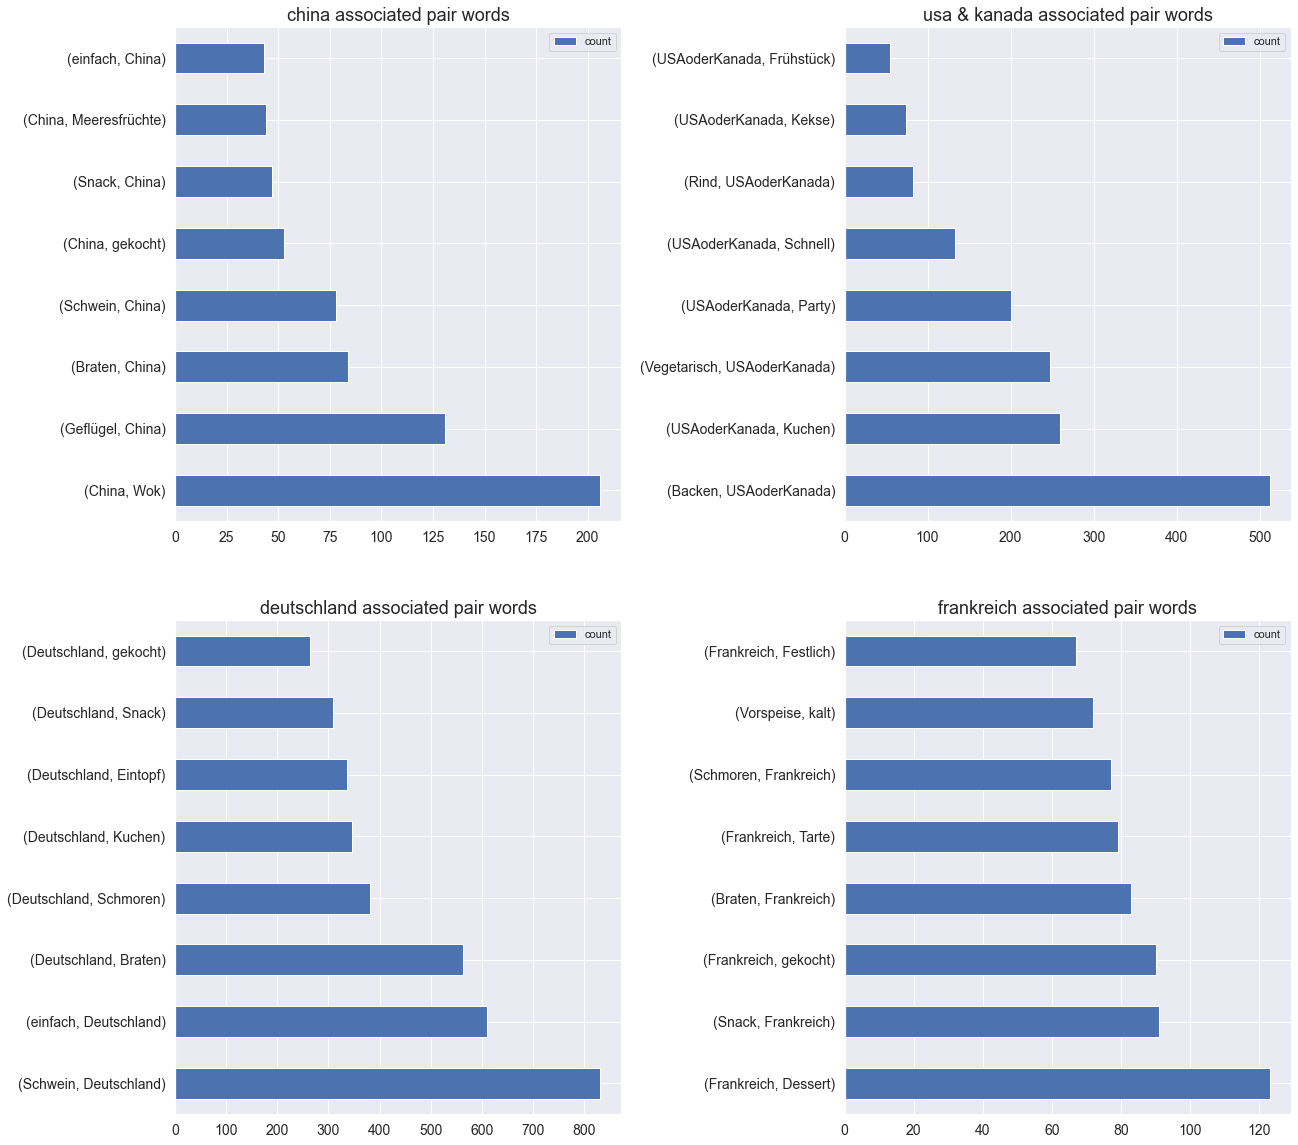

In [49]:
f,ax=plt.subplots(2,2,figsize=(20,20))
plt.subplots_adjust(wspace =0.5, hspace =0.2)
china_pair.plot.barh(ax=ax[0,0],width=0.5, fontsize = 14)
ax[0,0].set_title('china associated pair words', fontsize = 18)
deutschland_pair.plot.barh(ax=ax[1,0],width=0.5, fontsize = 14)
ax[1,0].set_title('deutschland associated pair words', fontsize = 18)
usa_pair.plot.barh(ax=ax[0,1],width=0.5, fontsize = 14)
ax[0,1].set_title('usa & kanada associated pair words', fontsize = 18)
frankreich_pair.plot.barh(ax=ax[1,1],width=0.5, fontsize = 14)
ax[1,1].set_title('frankreich associated pair words', fontsize = 18)

In [50]:
def generate_ngrams(text, n):
    words = text.split(' ')
    iterations = len(words) - n + 1
    for i in range(iterations):
        yield words[i:i + n]

In [57]:
def net_diagram(*country):
    ngrams = {}
    for title in data_country[data_country['country']==country[0]]['for pairwords']:
        for ngram in generate_ngrams(title, 2):
            ngram = ','.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

    ngrams_mws_df = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df.columns = ['count']
    ngrams_mws_df['country'] = country[0]
    ngrams_mws_df.reset_index(level=0, inplace=True)
    
    ngrams = {}
    for title in data_country[data_country.country==country[1]]['for pairwords']:
        for ngram in generate_ngrams(title, 2):
            ngram = ','.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1
                
    ngrams_mws_df1 = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df1.columns = ['count']
    ngrams_mws_df1['country'] = country[1]
    ngrams_mws_df1.reset_index(level=0, inplace=True)
    country1=ngrams_mws_df.sort_values('count',ascending=False)[:15]
    country2=ngrams_mws_df1.sort_values('count',ascending=False)[:15]

    df_final=pd.concat([country1,country2])
#     print(df_final)
    g = nx.from_pandas_edgelist(df_final,source='country',target='index')
   
    cmap = plt.cm.RdYlGn
    
    colors = [n for n in range(len(g.nodes()))]
    k = 0.35
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=df_final['count'].values*8, cmap = cmap, node_color=colors, edge_color='grey', font_size=15, width=3)
    plt.title("Top 15 associated pair words for %s and %s" %(country[0],country[1]), fontsize=30)
    plt.gcf().set_size_inches(30,30)
    plt.show()
    plt.savefig('network.png')


ValueError: s must be a scalar, or the same size as x and y

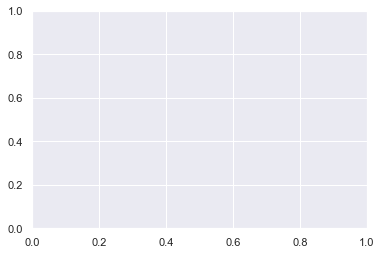

In [58]:
import networkx as nx
net_diagram('deutschland','frankreich')

In [ ]:
import networkx as nx
net_diagram('deutschland','frankreich')